In [1]:
!git clone https://github.com/sfarrukhm/making_models_efficient.git
import os
os.chdir("/kaggle/working/making_models_efficient/")
train_path = "/kaggle/input/intel-image-classification/seg_train/seg_train"
test_path = "/kaggle/input/intel-image-classification/seg_test/seg_test"
pred_path = "/kaggle/input/intel-image-classification/seg_pred/seg_pred"
checkpoint_path="./models/checkpoints"

Cloning into 'making_models_efficient'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 125 (delta 32), reused 21 (delta 4), pack-reused 57 (from 1)
Receiving objects: 100% (125/125), 84.83 MiB | 40.72 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [11]:
!git pull origin main


remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 1.46 KiB | 1.46 MiB/s, done.
From https://github.com/sfarrukhm/making_models_efficient
 * branch            main       -> FETCH_HEAD
   6d7a08c..33f6bec  main       -> origin/main
Updating 6d7a08c..33f6bec
Fast-forward
 utils/train_utils.py | 176 ++++++++++++++++++++++++++-------------------------
 1 file changed, 89 insertions(+), 87 deletions(-)


In [12]:
%%time

import torch
import warnings

warnings.filterwarnings("ignore")
device="cuda" if torch.cuda.is_available() else 'cpu'


!python train.py \
--model_type student\
--train_path {train_path}\
--test_path {test_path}\
--pred_path {pred_path}\
--optimizer SGD\
--batch_size 64\
--epochs 30\
--lr 0.01\
--device {device}\
--checkpoint_path /kaggle/working/making_models_efficient/models/checkpoints\
--model_name student.pth

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Loaded pretrained teacher model from /kaggle/working/making_models_efficient/models/checkpoints/teacher.pth

Training STUDENT model on cuda for 30 epochs...

[Student Epoch 1/30] Train Loss=5.1129, Train Acc=0.4998 | Val Loss=1.0809, Val Acc=0.5699
✅ Saved best student model to /kaggle/working/making_models_efficient/models/checkpoints/student.pth
[Student Epoch 2/30] Train 

### Test Model

In [2]:
from utils.data_utils import make_torch_dataset_from_image_folder
from torchvision import datasets, transforms
w,h=100,100
global_transforms = transforms.Compose([
  transforms.Resize((w, h)),
  # transforms.Grayscale(),
  transforms.ToTensor()
])

test_data=make_torch_dataset_from_image_folder(root=test_path,transform=global_transforms)
class_names = test_data.classes
class_num = len(class_names)
class_names, class_num

(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'], 6)

In [3]:
from torch.utils.data import DataLoader
from utils.model_utils import load_model
from models.student import StudentVisionEagle
from utils.train_evaluate_predict import make_prediction  # or wherever your function is
import torch
# Parameters
device = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint_path = "models/checkpoints"
model_name = "student.pth"
batch_size = 64

# Load the model
model = load_model(StudentVisionEagle, checkpoint_path, model_name, device)

# Test DataLoader (assuming test_data is already defined)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Make predictions
y_pred, y_true = make_prediction(model, test_dataloader, device)

# Convert to NumPy if needed
y_pred_np = y_pred.cpu().numpy()
y_true_np = y_true.cpu().numpy()

# Optional: evaluate
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true_np, y_pred_np, target_names=class_names))


              precision    recall  f1-score   support

   buildings       0.77      0.75      0.76       437
      forest       0.96      0.95      0.95       474
     glacier       0.83      0.73      0.78       553
    mountain       0.82      0.76      0.79       525
         sea       0.75      0.89      0.81       510
      street       0.77      0.80      0.78       501

    accuracy                           0.81      3000
   macro avg       0.81      0.81      0.81      3000
weighted avg       0.81      0.81      0.81      3000



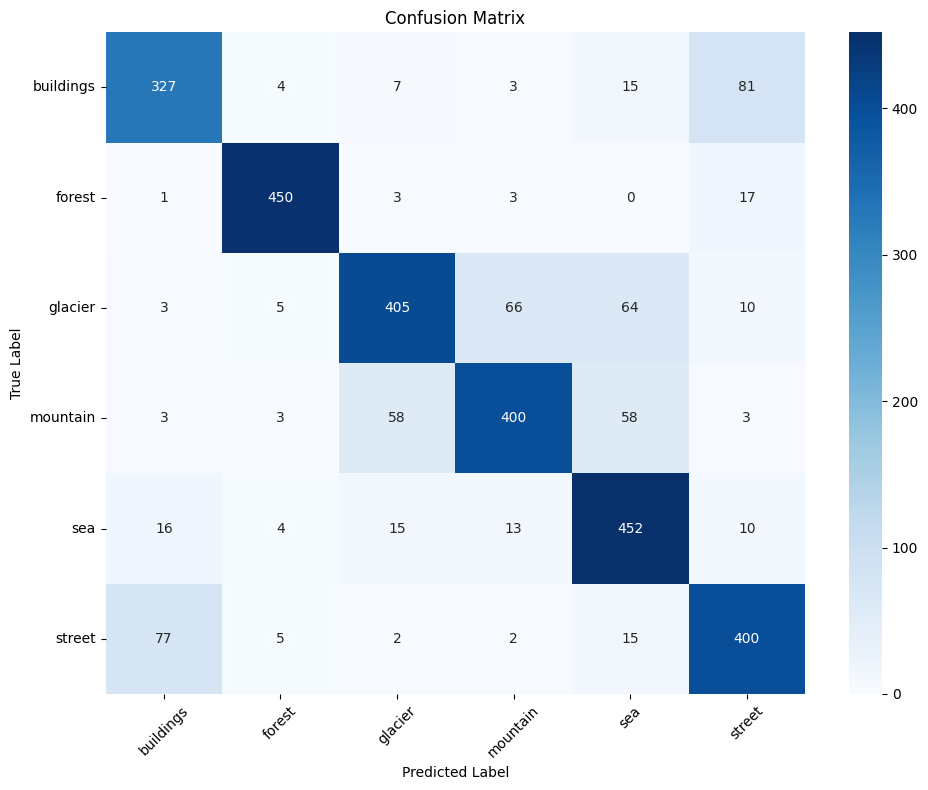

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names, normalize=False, figsize=(10, 8), cmap='Blues'):
    """
    Plots a confusion matrix using seaborn heatmap.
    
    Parameters:
        y_true (array-like): True class labels
        y_pred (array-like): Predicted class labels
        class_names (list): List of class names
        normalize (bool): If True, normalize the confusion matrix
        figsize (tuple): Size of the plot
        cmap (str): Colormap
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap=cmap,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix" + (" (Normalized)" if normalize else ""))
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


# Example use:
plot_confusion_matrix(
    y_true=y_true_np,
    y_pred=y_pred_np,
    class_names=class_names,
    normalize=False  # or True if you want percentages
)


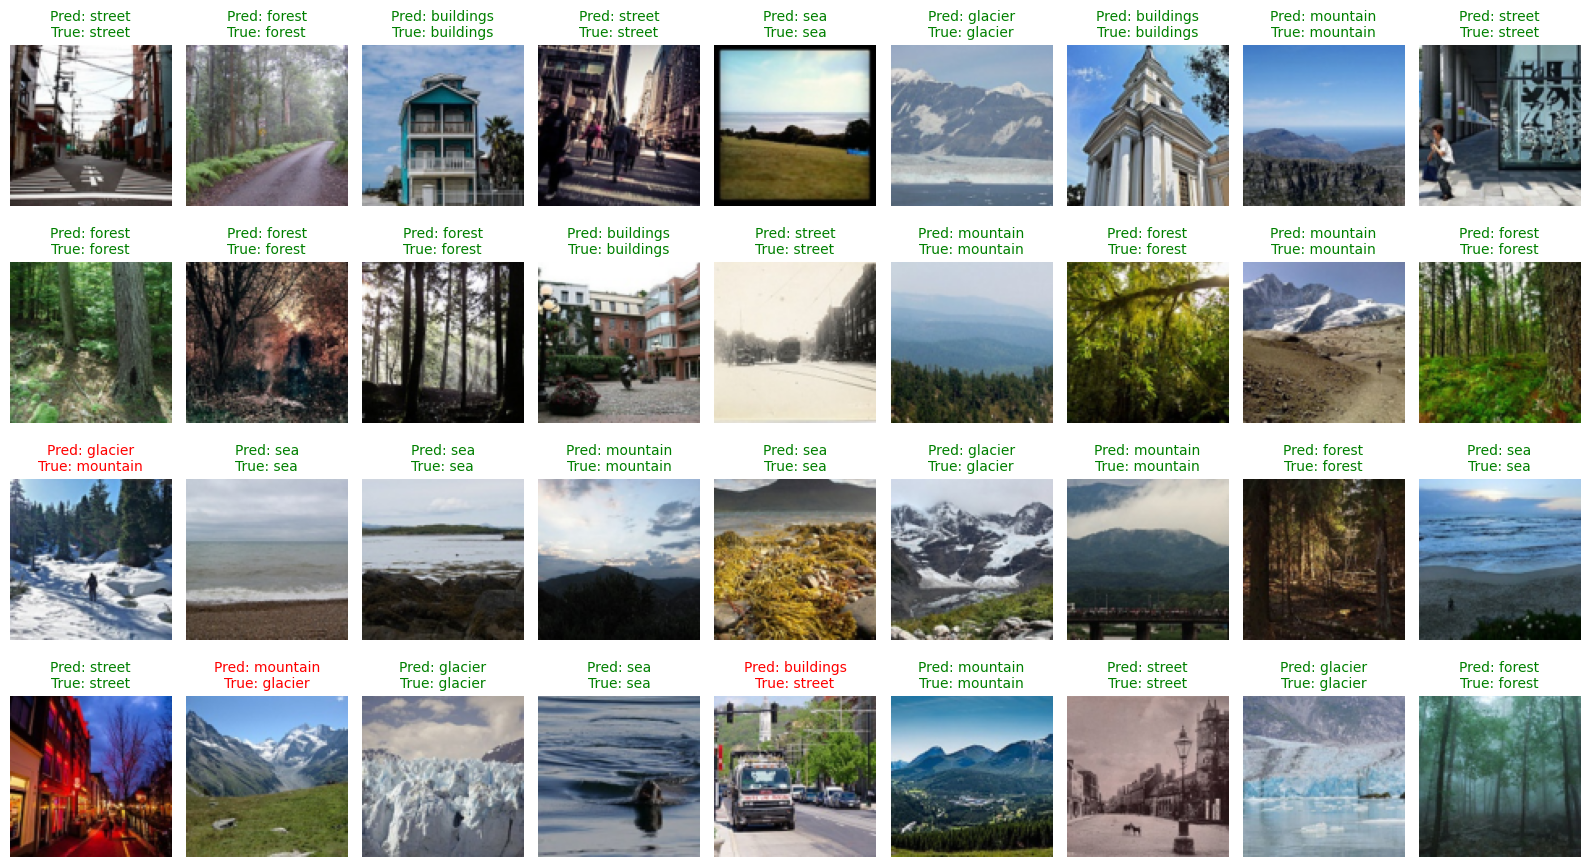

In [6]:
def plot_predictions(model, dataset, class_names, device='cuda' if torch.cuda.is_available() else 'cpu', 
                     rows=4, cols=9, figsize=(16, 9)):
    """
    Plot predictions of a model on randomly selected samples from the dataset.

    Args:
        model (torch.nn.Module): Trained model.
        dataset (torch.utils.data.Dataset): Dataset (must return (image, label)).
        class_names (list): List of class labels.
        device (str): 'cuda' or 'cpu'. Default: auto-detect.
        rows (int): Number of rows in the grid.
        cols (int): Number of columns in the grid.
        figsize (tuple): Size of the figure.
    """
    model.to(device)
    model.eval()
    plt.figure(figsize=figsize)

    for i in range(1, rows * cols + 1):
        plt.subplot(rows, cols, i)

        random_idx = torch.randint(0, len(dataset), size=(1,)).item()
        image, label = dataset[random_idx]

        with torch.inference_mode():
            pred = model(image.unsqueeze(0).to(device)).argmax(dim=1).item()

        # Plot image
        plt.imshow(image.permute(1, 2, 0).cpu())
        plt.axis('off')

        # Title formatting
        pred_class = class_names[pred]
        true_class = class_names[label]
        color = 'green' if pred == label else 'red'
        title = f"Pred: {pred_class}\nTrue: {true_class}"
        plt.title(title, fontsize=10, color=color)

    plt.tight_layout()
    plt.show()
# Plot predictions
plot_predictions(
    model=model,
    dataset=test_data,
    class_names=class_names,  # Should be a list of class names like ["buildings", "forest", ...]
    device=device,
    rows=4,
    cols=9
)